In [28]:
%matplotlib inline

import os,sys

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
from torch.autograd import Variable

import image_processing as ip
%load_ext autoreload
%autoreload 2

# 1 Data loading and pre-processing

## 1.1 Load the data

In [3]:
# Directory and files name
train_dir = "training/"
tr_image_dir = train_dir + "images/"
tr_label_dir = train_dir + "groundtruth/"

tr_image_files = os.listdir(tr_image_dir)
tr_label_files = os.listdir(tr_label_dir)

# Number of training samples
N = len(tr_image_files)

# Load the images and ground truth
img_train = []
label_train = []
for i in range(N):
    img = mpimg.imread(tr_image_dir + tr_image_files[i])
    label = mpimg.imread(tr_label_dir + tr_label_files[i])
    
    img_train.append(img)
    label_train.append(label)
    
img_train = np.asarray(img_train)
label_train = np.asarray(label_train)

print(img_train.shape, label_train.shape)

(100, 400, 400, 3) (100, 400, 400)


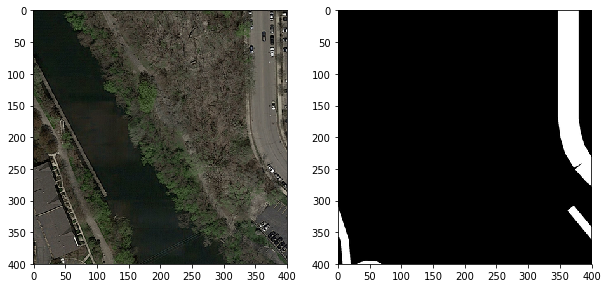

In [16]:
# Test the loading by showing image & ground truth
img_num = 0
# Show first image and its groundtruth image
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img_train[img_num])
plt.subplot(122)
plt.imshow(label_train[img_num], cmap='gray')

## 1.2 Pre-process the data

In [32]:
# Size of the window around the pixel (must be odd)
window_size = 21

x_train = img_train.copy()
y_train = label_train.copy()

# Pre-processing; for now do nothing
tx = x_train
ty = y_train

In [23]:
def get_window(image, window_size, i, j):
    """
    Extract the neighbourhood of (i,j) in image (mirror boundary conditions apply)
    Note that (i,j) = (y,x) in pixel coordinate (assuming image conventions)
    Input:
        image: the image array; size:(width, height, num_channel)
        window_size: size of the neighbourhood, should be odd
        i: the row-coordinate of the window's center
        j: the col-coordinate of the window's center
    Output:
        window: the neighbourhood array; size:(window_size, window_size, num_channel)
    """
    window = np.zeros((window_size, window_size, image.shape[2]))
    for ii in range(window_size):
        for jj in range(window_size):
            window[ii,jj,:] = ip.get_pixel(image, i + (ii - (window_size-1)/2), j + (jj - (window_size-1)/2))
    return window

def get_neighbourhoods(image, window_size):
    """
    Generate the neighbourhood of each pixel of the given image (mirror boundary conditions apply)
    Input:
        image: the image array; size:(width, height, num_channel)
        window_size: size of the neighbourhood, should be odd
    Output:
        neighbourhood: the neighbourhood array; size:(width*height, window_size, window_size, num_channel)
    """
    # Loop on each pixel of image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            yield get_window(image, window_size, i, j)

(151, 151, 3)


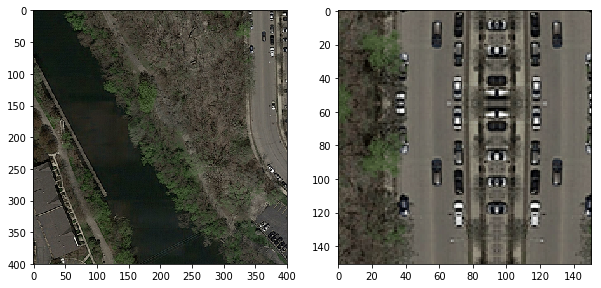

In [26]:
# Test neighbourhood by showing image and pixel's neighbourhood
# Can check if mirror boundary works too
wind = get_window(img_train[img_num], 151, 20, 380)

print(wind.shape)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img_train[img_num])
plt.subplot(122)
plt.imshow(wind)

## 1.3 Split the data

In [34]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)

    indices = np.random.permutation(y.shape[0])
    train_size = int(y.shape[0] * ratio)

    return x[indices[:train_size]], y[indices[:train_size]],  \
            x[indices[train_size:]], y[indices[train_size:]]

In [35]:
ratio = 0.66
seed = 1

# Build the train and validation/test sets
x_tr, y_tr, x_te, y_te = split_data(tx, ty, ratio, seed)

# 2 Learning

## 2.1 Define the model, loss, and optimizer

In [31]:
class NN(torch.nn.Module):
    def __init__(self, hidden_size):
        """
        TODO
        """
        super(NN, self).__init__()
        H = 3
        self.model = torch.nn.Sequential(
            torch.nn.Linear(window_size*window_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        """
        TODO
        """
        y_pred = self.model(x)
        return y_pred

# Learning rate
learning_rate = 1e-4
# Batch size (number of sample to feed the network for one iteration of training)
batch_size = 10
hidden_size = 3
    
network = NN(hidden_size)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

## 2.2 Train the network

In [36]:
def train(images, labels, model, lossfunc, optimizer, num_epoch, batch_size, verbose=False):
    """
    Train the neural networks with the given images and their labels.
    Input:
        images: the images from the train set; size:(num_image, width, height, num_channel)
                they should already be randomly permuted !
        labels: their ground truth (binary images); size:(num_image, width, height, 1)
        model: the PyTorch model (the neural network)
        lossfunc: the PyTorch loss function
        optimizer: the PyTorch optimizer
        num_epoch: the number of epoch <=> number of pass over the data
        batch_size: the number of samples in the mini-batch to perform one pass on
        verbose: boolean to choose to print or not the current status (default: False)
    """
    ### TODO ###
    for epoch in range(num_epoch):
        # TODO: Step 1 - create torch variables corresponding to features and labels
        inputs = Variable(torch.from_numpy(features))
        targets = Variable(torch.from_numpy(labels))

        # TODO: Step 2 - compute model predictions and loss
        outputs = model(inputs)
        loss = lossfunc(outputs, targets)
        
        # TODO: Step 3 - do a backward pass and a gradient update step
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss.data[0]))

# 3 Create a submission